## Notebook demonstrating LFMAP application for retrieval (section 4.3 in the paper)



In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from estimators.FM import FM,FM_distfunc,FM_T
from utils.fmap import p2p_to_FM, FM_to_p2p

### Data loading


In [19]:
data_folder='../data/'

all_latents = {"fast": torch.load(f"{data_folder}/embeddings_fast.pt"),"w2v": torch.load(f"{data_folder}/embeddings_w2v.pt")}
N=2000 # number of points in the graph
anchor_idx=torch.randperm(N)[:300]
anchors_o=torch.stack((anchor_idx,anchor_idx),1)
anchors_idx = { "w2v" : anchor_idx, "fast": anchor_idx}

a_x=all_latents["fast"][:N]
a_y=all_latents["w2v"][:N]

# anchors = { "fast": torch.load(f"{data_folder}/anchors_embeddings_fast.pt"), 
# "w2v" : torch.load(f"{data_folder}/anchors_embeddings_w2v.pt"), }
# anchors_idx = { "w2v" : get_idx(anchors["w2v"],all_latents["w2v"]),
#                 "fast": get_idx(anchors["fast"],all_latents["fast"])}

Phi_gt = np.arange(N) 

### Test basic functionalities


In [20]:
from utils.graph import build_graph

graph_algo = "knn"
graph_kernel='gaussian'
graph_similarity='euclidean'
m = 5

G_w2v = build_graph(all_latents["w2v"], algo=graph_algo, kernel=graph_kernel,
                     similarity=graph_similarity, m=m)
G_fast = build_graph(all_latents["fast"],  algo=graph_algo, kernel=graph_kernel,
                     similarity=graph_similarity, m=m)
print(f"Graphs k: w2v {G_w2v.k}, fast {G_fast.k}")

Graphs k: w2v 81, fast 81


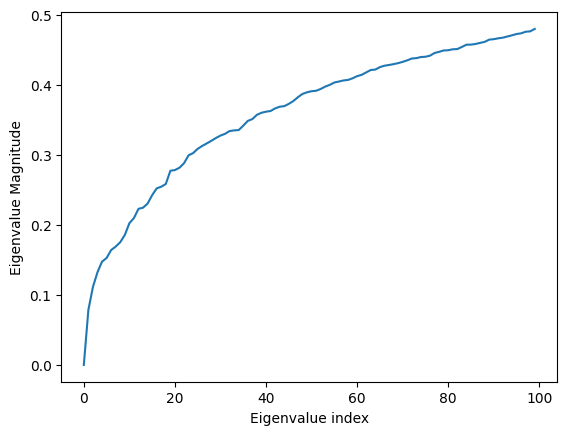

In [21]:
eigvals, eigvec  = G_w2v.eigen_decomp(k=100)

# plot eigenvalues
import matplotlib.pyplot as plt
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue Magnitude")
plt.plot(eigvals)
plt.show()

In [22]:
na = 4
fm_model = FM(a_x,a_y, anchors_o[:na,:],
                 graph_algo='knn',graph_similarity='angular',graph_kernel='singular',
                 num_eigs=50, descriptors=('dist_geod',),k=300)
fm_model.Cgt = p2p_to_FM(Phi_gt,fm_model.eigvecs1,fm_model.eigvecs2)


Is connected? True
Is connected? True
Computing functional map with descriptors:  ['dist_geod']


In [23]:
# plot the Cs
mm = max( (np.abs(fm_model.C).max(), np.abs(fm_model.Cgt).max()))
fig_C = make_subplots(rows=1, cols=2, subplot_titles=("Ground truth", "Computed"))
fig_C.add_trace(go.Heatmap(z=fm_model.Cgt, colorscale='RDBu'), row=1, col=1)
fig_C.add_trace(go.Heatmap(z=fm_model.C, colorscale='RDBu'), row=1, col=2)
fig_C.update_layout(title_text="Functional maps", scene=dict(aspectmode="data"), autosize=False, width=1000, height=500)
fig_C.update_traces(zmin=-mm, zmax=mm)
fig_C.update_yaxes(autorange="reversed")

## Define utility functions


In [24]:
from scipy.optimize import leastsq
import torch.nn.functional as F


def get_idx(anchors,latents):
    return torch.where(torch.cdist(anchors.double(),latents.double())<=1e-6)[1]


def compute_mrr(res, gt_indxs):
    """
    Compute the Mean Reciprocal Rank (MRR) of the results.
    res: tensor of shape (n_samples, n_candidates)
    gt_indxs: ground truth indices of the correct candidates for each sample (n_samples, 1)
    """
    if gt_indxs.dim() == 1:
        gt_indxs = gt_indxs.unsqueeze(1)
    eq_matrix = torch.eq(res, gt_indxs)
    mrr=[]
    for i in range(eq_matrix.shape[0]):
        # check if there is a match
        if torch.any(eq_matrix[i]):
            rank = torch.argwhere(eq_matrix[i])[0,0]+1
        else:
            rank = eq_matrix.shape[1]
        mrr.append(1/rank)
    return torch.tensor(mrr).mean()


def relative(x,a):
    x=x/x.norm(dim=1,keepdim=True)
    a=a/a.norm(dim=1,keepdim=True)
    return x@a.T

    
def cosine_similarity_cdist(x1, x2,dim=1):
    """
    Calculate pairwise cosine similarity between two sets of vectors.
    
    Args:
    x1 (torch.Tensor): Tensor of shape (N, D) where N is the number of vectors and D is dimensionality.
    x2 (torch.Tensor): Tensor of shape (M, D) where M is the number of vectors.
    
    Returns:
    torch.Tensor: Tensor of shape (N, M) containing cosine similarities between vectors.
    """
    # Normalize each vector in x1 and x2 to have unit norm
    x1_norm = x1 / x1.norm(dim=dim, keepdim=True)
    x2_norm = x2 / x2.norm(dim=dim, keepdim=True)
    
    # Compute the dot product between all pairs
    if dim==1:
        cosine_sim = torch.mm(x1_norm, x2_norm.t())
    elif dim==2:
        cosine_sim = torch.einsum("abc,acb-> ab",x1_norm, x2_norm.permute(0,2,1))

    return cosine_sim

def acos_jitter(x, epsilon=1e-7):
    x_clamp = torch.clamp(x, -1 + epsilon, 1 - epsilon)
    x_acos = torch.acos(x_clamp)

    return x_acos

def angular_distance_cdist(x1, x2, dim=1):
    """
    Calculate pairwise angular distance between two sets of vectors.
    
    Args:
    x1 (torch.Tensor): Tensor of shape (N, D) where N is the number of vectors and D is dimensionality.
    x2 (torch.Tensor): Tensor of shape (M, D) where M is the number of vectors.
    
    Returns:
    torch.Tensor: Tensor of shape (N, M) containing angular distances between vectors.
    """
    # Compute the cosine similarity between x1 and x2
    cosine_sim = cosine_similarity_cdist(x1, x2,dim=dim)
        
    # Compute the angular distance
    # cosine_sim = torch.clamp(cosine_sim, -1.0, 1.0)
    # angular_dist = 1 - cosine_sim
    angular_dist = acos_jitter(cosine_sim)
    
    return angular_dist

def distance_function(p, N, metric='euclidean'):
    """
    Computes the distance function from a point p to the point cloud N, using a specific metric.
    
    Args:
    - p (Tensor): A tensor of shape (num_p, D,) representing a point in D-dimensional space.
    - N (Tensor): A tensor of shape (num_points, D) representing a point cloud in D-dimensional space.
    - metric (str): The metric to use for computing distances. Can be 'euclidean' or 'cosine'.
    
    Returns:
    - Tensor: A tensor of shape (num_p,num_points,) containing the distances from p to each point in N.
    """
    if metric == 'euclidean':
        D = torch.cdist(p, N, p=2)
    elif metric == 'cosine':
        # return 1 - F.cosine_similarity(N, p.unsqueeze(0), dim=1).squeeze()
        D = 1- cosine_similarity_cdist(p, N,dim=1)
    elif metric == 'angular':
        D = angular_distance_cdist(p, N,dim=1)
    else:
        raise ValueError("Unknown metric. Must be 'euclidean' or 'cosine'.")
    
    # smooth the distances
    # D = torch.exp(D)
    D = torch.pow(D,2)
    return D
    
def inverse_distance_function(d,N,dist_f, y0 = None, metric='euclidean', solver='leastsq',
                              n_iter=100, lr=0.01, device='cpu'):
    """ 
    Given a distance d, compute the inverse distance function and return the point p.

    Args:
    - d (Tensor): A tensor of shape (num_points,n_d) containing distances.
    - N (Tensor): A tensor of shape (num_points, D) representing a point cloud in D-dimensional space.
    - dist_f (function): The distance function to use for computing distances. 
    - metric (str): The metric to use for computing distances. Can be 'euclidean' or 'cosine'.

    Returns:
    - Tensor: A tensor of shape (n_d,D) representing the point p.
    """

    x0 = N[d.argmin(dim=0)] # initial guess for the point p, size n_d x D

    # compute the maximum distance between points in N using cdist
    # max_dist = torch.cdist(N, N, p=2).max()

    if solver == "adam":
        d = torch.tensor(d, dtype=x0.dtype, device=device)
        N = torch.tensor(N, dtype=x0.dtype, device=device)
        if y0 is not None:
            y0 = torch.tensor(y0, dtype=x0.dtype, device=device)

    def f(x):
        delta_d = d - dist_f(N,x, metric=metric)
        # considet only the values for which d < (0.5 * max_dist)
        # delta_d = delta_d * (d < (0.3 * torch.max(d))).float()
        return  delta_d
    
    if solver == "leastsq":
        p, cov_p, info, message = leastsq(f, x0, full_output=True)[:4]

        energy_diff = (sum(info["fvec"])**2 - sum(f(x0).numpy())**2) 
        print("Energy final: ", sum(info["fvec"])**2)
        print("Energy diff: ", energy_diff)
        print("Messaeg: ", message)
        p = torch.tensor(p, dtype=d.dtype)
    elif solver == "adam":
        p = torch.tensor(x0, requires_grad=True, device=device)
        optimizer = torch.optim.Adam([p], lr=lr)
        print(f"Adam solver: {n_iter} iterations, lr={lr}")
        for i in range(n_iter):
            optimizer.zero_grad()
            loss = f(p).norm()
            # if y0 is not None:
            #     dist_f(p,p, metric=metric)
                # loss += (dist_f(p,p, metric=metric) - dist_f(y0,y0, metric=metric)).norm()
            if i % 150 == 0:
                print(f"{i}: {loss.item()}")
            loss.backward()
            optimizer.step()
        print(f"Final loss: {loss.item()}")
        p = p.cpu().detach()
    elif solver == "sgd":
        p = torch.tensor(x0, requires_grad=True)
        optimizer = torch.optim.SGD([p], lr=lr)
        for i in range(n_iter):
            optimizer.zero_grad()
            loss = f(p).norm()
            loss.backward()
            optimizer.step()
        p = p.detach()
    else:
        raise ValueError("Unknown solver.")
        
    return p

def transformX(self, x, metric='euclidean', solver='adam', n_iter=1000, lr=1e-5):
        """
        Transform point from X to Y

        Args:
        - x (Tensor): A tensor of shape (num_points, D,) representing a point in D-dimensional space.
        - metric (str): The metric to use for computing distances. Can be 'euclidean' or 'cosine'.
        - solver (str): The solver to use for computing the inverse distance function. Can be 'leastsq' or 'adam'.
        - n_iter (int): The number of iterations to use for the solver.
        - lr (float): The learning rate to use for the solver.

        Returns:
        - Tensor: A tensor of shape (num_points, D,) representing the transformed point in Y.
        """
        if type(x) is not torch.Tensor:
          x=torch.tensor(x)
        if type(self.X) is not torch.Tensor:
          x=torch.tensor(self.X)
        dX = distance_function(self.X, x,  metric=metric).numpy() # dist matrix with size nX x num_points
        dt_C = self.eigvecs2 @ self.C @ (self.eigvecs1.T @ dX) #  dist matrix with size nY x num_points

        y = inverse_distance_function(torch.tensor(dt_C),torch.tensor(self.Y),
                                      dist_f=distance_function, metric=metric, 
                                        solver=solver, n_iter=n_iter, lr=lr, device='cuda' if torch.cuda.is_available() else 'cpu')
        
        return y

def transform_distF(C, X, Y, eigvecs1, eigvecs2, x, metric='euclidean', solver='adam', n_iter=1000, lr=1e-5):
        if type(x) is not torch.Tensor:
            x=torch.tensor(x)
        if type(X) is not torch.Tensor:
          x=torch.tensor(X)
        dX = distance_function(X, x,  metric=metric).numpy() # dist matrix with size nX x num_points
        dt_C = eigvecs2 @ C @ (eigvecs1.T @ dX) #  dist matrix with size nY x num_points

        y = inverse_distance_function(torch.tensor(dt_C),torch.tensor(Y), 
                                      dist_f=distance_function, metric=metric, 
                                        solver=solver, n_iter=n_iter, lr=lr, device='cuda' if torch.cuda.is_available() else 'cpu')
        
        return y


In [25]:
Xtest = all_latents["fast"][2000:2000+1000]
Ytest = all_latents["w2v"][2000:2000+1000]
a_xt = transformX(fm_model, Xtest, metric='cosine', solver='adam',
                   n_iter=1500, lr=1e-2)

D=cosine_similarity_cdist(a_xt,Ytest)
res=D.topk(200)[1]
score = compute_mrr(res, torch.arange(Ytest.shape[0]))
print(f"Score: {score}")

/tmp/ipykernel_715958/828581855.py:203: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_715958/828581855.py:133: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_715958/828581855.py:134: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_715958/828581855.py:153: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Adam solver: 1500 iterations, lr=0.01
0: 214.52316284179688
150: 73.15264892578125
300: 72.78096008300781
450: 72.77395629882812
600: 72.77371215820312
750: 72.7737045288086
900: 72.7737045288086
1050: 72.7737045288086
1200: 72.7737045288086
1350: 72.77371215820312
Final loss: 72.77377319335938
Score: 0.8685668706893921


## Baseline Latent Translation

In [29]:
from torch import nn
 
class svd_align():

    def __init__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        assert x.size(1) == y.size(
            1
        ), f"Dimension mismatch between {x.size(1)} and {y.size(1)}. Forgot some padding/truncation transforms?"

        #  Compute the translation vector that aligns A to B using SVD.
        u, sigma, vt = torch.svd((y.T @ x).T)
        translation_matrix = u @ vt.T

        self.translation_matrix = torch.as_tensor(translation_matrix, dtype=x.dtype, device=x.device)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.translation_matrix

class sgd_affine:
    def __init__(self, x: torch.Tensor, y: torch.Tensor, num_steps: int = 300, lr: float = 1e-3, random_seed: int = None):
        super().__init__()

        assert x.size(1) == y.size(
            1
        ), f"Dimension mismatch between {x.size(1)} and {y.size(1)}. Forgot some padding/truncation transforms?"

        self.translation = nn.Linear(x.size(1), y.size(1), bias=True)
        self.num_steps = num_steps
        self.lr = lr
        self.random_seed = random_seed

        self.fit(x, y)

    def fit(self, x: torch.Tensor, y: torch.Tensor) -> None:
        with torch.random.fork_rng():
            # seed_everything(self.random_seed)
            with torch.enable_grad():
                optimizer = torch.optim.Adam(self.translation.parameters(), lr=self.lr)

                for _ in range(self.num_steps):
                    optimizer.zero_grad()
                    loss = F.mse_loss(self.translation(x), y)
                    loss.backward()
                    optimizer.step()
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.translation(x)

class lstsq_align:

    def __init__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        assert x.size(1) == y.size(
            1
        ), f"Dimension mismatch between {x.size(1)} and {y.size(1)}. Forgot some padding/truncation transforms?"

        #  Compute the translation vector that aligns A to B using SVD.
        translation_matrix = torch.linalg.lstsq(x, y).solution

        self.translation_matrix = torch.as_tensor(translation_matrix, dtype=x.dtype, device=x.device)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.translation_matrix

class lstsq_ortho_align:

    def __init__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        assert x.size(1) == y.size(
            1
        ), f"Dimension mismatch between {x.size(1)} and {y.size(1)}. Forgot some padding/truncation transforms?"

        #  Compute the translation vector that aligns A to B using SVD.
        translation_matrix = torch.linalg.lstsq(x, y).solution
        U, _, Vt = torch.svd(translation_matrix)
        translation_matrix = U @ Vt.T

        self.translation_matrix = torch.as_tensor(translation_matrix, dtype=x.dtype, device=x.device)
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.translation_matrix
    
Transl_methods = {
    "svd": svd_align,
    "linear": lstsq_align,
    "linear_ortho": lstsq_ortho_align,
    "sgd_affine": sgd_affine
}

In [30]:
def transform_Translation(C, X, Y, eigvecs1, eigvecs2, x, transformation='linear'):
        """
        Transform point from X to Y
        """
        Phi_flat = FM_to_p2p(C, eigvecs1, eigvecs2,  use_adj=False, n_jobs=1) # (n1,), indices of the closest point in the first shape for each point in the second shape

        align_class = Transl_methods[transformation](X, Y[Phi_flat])
        return align_class(x)


In [31]:
#check LFMAP
Xtest = all_latents["fast"][2000:2000+1000]
Ytest = all_latents["w2v"][2000:2000+1000]
a_xt = transform_Translation(fm_model.C, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
                             Xtest, transformation='sgd_affine' )
D=cosine_similarity_cdist(a_xt,Ytest)
res=D.topk(200)[1]
score = compute_mrr(res, torch.arange(Ytest.shape[0]))
print(f"Score: {score}")

Score: 0.9970883131027222


## Grid experiments on num of anchors

In [32]:
fmaps=[]
anchors_list=[]
n_anchors =  [2,5,10,25,50,75,100,150,200,300] # [2,5,10,50,100,150,300]
fm_model = FM(a_x,a_y, anchors_o[:4,:],
                 graph_algo='knn',graph_similarity='angular',graph_kernel='singular',
                 num_eigs=50, descriptors=('dist_geod',),k=300)
fm_model.Cgt = p2p_to_FM(Phi_gt,fm_model.eigvecs1,fm_model.eigvecs2)

for na in n_anchors:
    fm_model.anchors = anchors_o[:na,:]

    fm_model.compute_descriptors()
    fm_model.fit()

    fmaps.append(fm_model.C)
    anchors_list.append(fm_model.anchors)

Is connected? True
Is connected? True
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']
Computing functional map with descriptors:  ['dist_geod']


### computing LFM results and baselines

In [37]:
#executing this cell is gonna take \approx 15-20 mins, optionally load the results from ../Results/RetrievalAnchors_fast_w2v.pkl (se next cell)

# dist transf
# svd, sgd_affine, lstsq_align, lstsq_ortho_align,
methods = ['Transl svd Fmap', 'Transl sgd_affine Fmap', 'Transl linear Fmap', 'Transl lstsq_ortho Fmap',
           'Transl svd FmapGT', 'Transl sgd_affine FmapGT', 'Transl linear FmapGT', 'Transl lstsq_ortho FmapGT',
           'Transl svd Anchors', 'Transl sgd_affine Anchors', 'Transl linear Anchors', 'Transl lstsq_ortho Anchors',
           'Transl svd all', 'Transl sgd_affine all', 'Transl lstsq all', 'Transl lstsq_ortho all',
            'Relative Fmap', 'Relative', 'DistF FmapGT', ]
methods = ['Transl Fmap', 'Trasl Anchors', 'Transl all', 'Relative Fmap', 'Relative', 'Relative all']
T_methods = ['linear', 'linear_ortho', 'svd', 'sgd_affine', ]
distF_params = {'metric': 'cosine', 'solver': 'adam', 'n_iter': 500, 'lr': 1e-2}

Xtest = all_latents["fast"][2000:]
Ytest = all_latents["w2v"][2000:]
Phigt_flat = torch.arange(Ytest.shape[0])
# apply permutations
Phigt_flat = torch.randperm(Ytest.shape[0])
# Ytest = Ytest[Phigt_flat]
Xtest = Xtest[Phigt_flat]
results={}

def compute_score(a_xt,Ytest, max_k = 200):
    D=cosine_similarity_cdist(a_xt,Ytest)
    res=D.topk(max_k)[1]
    score = compute_mrr(res, Phigt_flat)
    return score


for i, na in enumerate(n_anchors): 
    print(f"## Anchors: {na}")
    results['anchors_'+str(na)]={}
    
    C = fmaps[i]
    # Dist F
    if 'DistF Fmap' in  methods:
        metric_distF = distF_params['metric']
        # a_xt = transform_distF(C, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
        #                 Xtest, **distF_params)
        # results['anchors_'+str(na)][f'DistF Fmap ({metric_distF})'] = compute_score(a_xt,Ytest, max_k = 200)

        dX = distance_function(fm_model.X, Xtest,  metric=metric_distF).numpy() # dist matrix with size nX x num_points
        dt_C = fm_model.eigvecs2 @ C @ (fm_model.eigvecs1.T @ dX) #  dist matrix with size nY x num_points
        dY = distance_function(fm_model.Y, Ytest,  metric=metric_distF) # dist matrix with size nX x num_points
        # eucl
        # D=torch.cdist(a_xt,Ytest)
        # res=D.topk(200, largest=False)[1]
        results['anchors_'+str(na)][f'DistF Fmap ({metric_distF})'] = compute_mrr(res, torch.arange(Ytest.shape[0]))
        print(f"Fmap+DistF: {results['anchors_'+str(na)][f'DistF Fmap ({metric_distF})']}")

    # Fmap Translation
    if 'Transl Fmap' in methods:
        for T_method in T_methods:
            a_xt = transform_Translation(C, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
                                        Xtest, transformation=T_method)
            results['anchors_'+str(na)][f'Transl {T_method} Fmap'] = compute_score(a_xt,Ytest, max_k = 200)
            print(f"f'Transl {T_method} Fmap': {results['anchors_'+str(na)][f'Transl {T_method} Fmap']}")

    anchors = anchors_list[i]
    if 'Trasl Anchors' in methods:
        for T_method in T_methods:
            T_class = Transl_methods[T_method](fm_model.X[anchors[:,0]], fm_model.Y[anchors[:,1]])
            a_xt = T_class(Xtest)
            # T_baseline = torch.linalg.lstsq(fm_model.X[anchors[:,0]],fm_model.Y[anchors[:,1]]).solution
            # a_xt = Xtest @ T_baseline
            results['anchors_'+str(na)][f'Trasl {T_method} Anchors'] = compute_score(a_xt,Ytest, max_k = 200)
            print(f"f'Trasl {T_method}  Anchors': {results['anchors_'+str(na)][f'Trasl {T_method} Anchors']}")
    
    if "Relative Fmap" in methods:
        metric_distF = distF_params['metric']
        dX = distance_function(fm_model.X, Xtest,  metric=metric_distF).numpy() # dist matrix with size nX x num_points
        dt_C = C @ (fm_model.eigvecs1.T @ dX) #  dist matrix with size k x num_points
        dY = distance_function(fm_model.Y, Ytest,  metric=metric_distF) # dist matrix with size k x num_points
        dY = torch.tensor(fm_model.eigvecs2.T, dtype=dY.dtype ) @ dY
        dt_C = torch.tensor(dt_C, dtype=dY.dtype)
        results['anchors_'+str(na)][f'Rel + Fmap ({metric_distF})']=compute_score(dt_C.T,dY.T, max_k = 200)
        print(f"Fmap+Relative: {results['anchors_'+str(na)][f'Rel + Fmap ({metric_distF})']}")

    
    if 'Relative' in methods:
        rx=relative(Xtest,fm_model.X[anchors[:,0]])
        ry=relative(Ytest,fm_model.Y[anchors[:,1]])
        results['anchors_'+str(na)]['Relative']=compute_score(rx,ry, max_k = 200)
        print(f"Relative: {results['anchors_'+str(anchors.shape[0])]['Relative']}")

print("## All")

if 'DistF FmapGT' in  methods:
    a_xt = transform_distF(fm_model.Cgt, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
                        Xtest,  **distF_params)
    score = compute_score(a_xt,Ytest, max_k = 200)
    print(f"FmapGT+DistF: {score}")

    for i, na in enumerate(n_anchors): 
        results['anchors_'+str(na)][f'DistF FmapGT ({distF_params["metric"]})'] = score
    
if 'Transl FmapGT' in  methods:
    for T_method in T_methods:
        a_xt = transform_Translation(fm_model.Cgt, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
                                    Xtest, transformation=T_method)
        score = compute_score(a_xt,Ytest, max_k = 200)
        print(f"f'Transl {T_method} FmapGT': {score}")

        for i, na in enumerate(n_anchors): 
            results['anchors_'+str(na)][f'Transl {T_method} FmapGT'] = score

if 'Transl all' in methods:
    for T_method in T_methods:
        # T_baseline = torch.linalg.lstsq(fm_model.X,fm_model.Y).solution
        # a_xt = Xtest @ T_baseline
        T_class = Transl_methods[T_method](fm_model.X, fm_model.Y)
        a_xt = T_class(Xtest)
        score = compute_score(a_xt,Ytest, max_k = 200)
        print(f"Transl  {T_method} all: {score}")

        for i, na in enumerate(n_anchors): 
            results['anchors_'+str(na)][f'Transl {T_method} all'] = score

if 'Relative all' in methods:
    rx=relative(Xtest,fm_model.X)
    ry=relative(Ytest,fm_model.Y)
    score = compute_score(rx,ry, max_k = 200)
    print(f"Relative all: {score}")

    for i, na in enumerate(n_anchors): 
        results['anchors_'+str(na)]['Relative all'] = score




# save results in a pickle file
import pickle
import os
os.makedirs('../Results/',exist_ok=True)

with open(f'../Results/RetrievalAnchors_fast_w2v.pkl', 'wb') as f:
    pickle.dump(results, f)

## Anchors: 2
f'Transl linear Fmap': 0.0091654472053051
f'Transl linear_ortho Fmap': 0.008648457005620003
f'Transl svd Fmap': 0.010413548909127712
f'Transl sgd_affine Fmap': 0.009203767403960228
f'Trasl linear  Anchors': 0.005584253929555416
f'Trasl linear_ortho  Anchors': 0.005748900584876537
f'Trasl svd  Anchors': 0.005719205364584923
f'Trasl sgd_affine  Anchors': 0.005645114928483963
Fmap+Relative: 0.007802629377692938
Relative: 0.005806822795420885
## Anchors: 5
f'Transl linear Fmap': 0.9901440143585205
f'Transl linear_ortho Fmap': 0.9905697703361511
f'Transl svd Fmap': 0.9904065728187561
f'Transl sgd_affine Fmap': 0.986362099647522
f'Trasl linear  Anchors': 0.007148183416575193
f'Trasl linear_ortho  Anchors': 0.0071785026229918
f'Trasl svd  Anchors': 0.007433303166180849
f'Trasl sgd_affine  Anchors': 0.0070513347163796425
Fmap+Relative: 0.8463249802589417
Relative: 0.011271068826317787
## Anchors: 10
f'Transl linear Fmap': 0.9901440143585205
f'Transl linear_ortho Fmap': 0.99056977

In [33]:
# load results from a pickle file
import pickle
with open(f'../Results/RetrievalAnchors_fast_w2v.pkl', 'rb') as f:
    results = pickle.load(f)

In [34]:
# plot results
# plot the results as the number of anchors increases (with plotly)
fig = go.Figure()
methods_names = list(results['anchors_'+str(n_anchors[0])].keys())
methods_names = ['Transl linear_ortho Fmap','Trasl linear_ortho Anchors', 'Transl linear_ortho all',
                 'Rel + Fmap (cosine)', 'Relative', 'Relative all',]
for method in methods_names:
    scores = [results[res][method] for res in results.keys() ]
    line_style = {'dash': ('dash' if ('GT' in method or 'all' in method) else 'solid'), 'width': 1}
    fig.add_trace(go.Scatter(x=n_anchors, y=scores, mode='lines+markers', name=method, line=line_style))

fig.update_layout(title='MRR Scores', xaxis_title='n anchors', yaxis_title='Score')
# white background color
fig.update_layout(plot_bgcolor='white')
# grey grid lines
fig.update_layout(yaxis=dict(gridcolor='#DCDCDC'))
fig.update_layout(xaxis=dict(gridcolor='#DCDCDC'))
fig.show()

# Grid experiment on eigenvectors num

In [11]:
fmaps=[]
anchors_list=[]
n_anchor =  5
anchor = anchors_o[:n_anchor,:]
n_eigs = [12,25,50,100,200]

for n_eig in n_eigs:
    fm_model = FM(a_x,a_y, anchor,
                 graph_algo='knn',graph_similarity='angular',graph_kernel='singular',
                 num_eigs=n_eig, descriptors=('dist_geod',),k=300)
    fm_model.Cgt = p2p_to_FM(Phi_gt,fm_model.eigvecs1,fm_model.eigvecs2)

    fmaps.append(fm_model.C)

Is connected? True
Is connected? True
Computing functional map with descriptors:  ['dist_geod']
Is connected? True
Is connected? True
Computing functional map with descriptors:  ['dist_geod']
Is connected? True
Is connected? True
Computing functional map with descriptors:  ['dist_geod']
Is connected? True
Is connected? True
Computing functional map with descriptors:  ['dist_geod']
Is connected? True
Is connected? True
Computing functional map with descriptors:  ['dist_geod']


In [ ]:
methods = ['Transl Fmap', 'Transl FmapGT','Trasl Anchors', 'Transl all', 'Relative Fmap', "Relative FmapGT", 'Relative', 'Relative all']
T_methods = ['linear', 'linear_ortho', 'svd', 'sgd_affine', ]
distF_params = {'metric': 'cosine', 'solver': 'adam', 'n_iter': 500, 'lr': 1e-2}

fmaps=[]
anchors_list=[]
n_anchor =  5
anchors = anchors_o[:n_anchor,:]
n_eigs = [12,25,50,100,200] 
    
Xtest = all_latents["fast"][2000:]
Ytest = all_latents["w2v"][2000:]
Phigt_flat = torch.arange(Ytest.shape[0])
# apply permutations
Phigt_flat = torch.randperm(Ytest.shape[0])
# Ytest = Ytest[Phigt_flat]
Xtest = Xtest[Phigt_flat]
results={}

def compute_score(a_xt,Ytest, max_k = 200):
    D=cosine_similarity_cdist(a_xt,Ytest)
    res=D.topk(max_k)[1]
    score = compute_mrr(res, Phigt_flat)
    return score


for i, na in enumerate(n_eigs): 
    print(f"## Eigs: {na}")
    results['eigs_'+str(na)]={}
    
    fm_model = FM(a_x,a_y, anchors,
                 graph_algo='knn',graph_similarity='angular',graph_kernel='singular',
                 num_eigs=na, descriptors=('dist_geod',),k=300)
    fm_model.Cgt = p2p_to_FM(Phi_gt,fm_model.eigvecs1,fm_model.eigvecs2)
    C = fm_model.C

    # Dist F
    if 'DistF Fmap' in  methods:
        metric_distF = distF_params['metric']
        # a_xt = transform_distF(C, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
        #                 Xtest, **distF_params)
        # results['anchors_'+str(na)][f'DistF Fmap ({metric_distF})'] = compute_score(a_xt,Ytest, max_k = 200)

        dX = distance_function(fm_model.X, Xtest,  metric=metric_distF).numpy() # dist matrix with size nX x num_points
        dt_C = fm_model.eigvecs2 @ C @ (fm_model.eigvecs1.T @ dX) #  dist matrix with size nY x num_points
        dY = distance_function(fm_model.Y, Ytest,  metric=metric_distF) # dist matrix with size nX x num_points
        # eucl
        # D=torch.cdist(a_xt,Ytest)
        # res=D.topk(200, largest=False)[1]
        results['eigs_'+str(na)][f'DistF Fmap ({metric_distF})'] = compute_mrr(res, torch.arange(Ytest.shape[0]))
        print(f"Fmap+DistF: {results['eigs_'+str(na)][f'DistF Fmap ({metric_distF})']}")

    # Fmap Translation
    if 'Transl Fmap' in methods:
        for T_method in T_methods:
            a_xt = transform_Translation(C, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
                                        Xtest, transformation=T_method)
            results['eigs_'+str(na)][f'Transl {T_method} Fmap'] = compute_score(a_xt,Ytest, max_k = 200)
            print(f"f'Transl {T_method} Fmap': {results['eigs_'+str(na)][f'Transl {T_method} Fmap']}")
    
    if 'Transl FmapGT' in  methods:
        for T_method in T_methods:
            a_xt = transform_Translation(fm_model.Cgt, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
                                        Xtest, transformation=T_method)
            score = compute_score(a_xt,Ytest, max_k = 200)
            print(f"f'Transl {T_method} FmapGT': {score}")
            results['eigs_'+str(na)][f'Transl {T_method} FmapGT'] = score
    
    if "Relative Fmap" in methods:
        metric_distF = distF_params['metric']
        dX = distance_function(fm_model.X, Xtest,  metric=metric_distF).numpy() # dist matrix with size nX x num_points
        dt_C = C @ (fm_model.eigvecs1.T @ dX) #  dist matrix with size k x num_points
        dY = distance_function(fm_model.Y, Ytest,  metric=metric_distF) # dist matrix with size k x num_points
        dY = torch.tensor(fm_model.eigvecs2.T, dtype=dY.dtype ) @ dY
        dt_C = torch.tensor(dt_C, dtype=dY.dtype)
        results['eigs_'+str(na)][f'Rel + Fmap ({metric_distF})']=compute_score(dt_C.T,dY.T, max_k = 200)
        print(f"Fmap+Relative: {results['eigs_'+str(na)][f'Rel + Fmap ({metric_distF})']}")

    if "Relative FmapGT" in methods:
        metric_distF = distF_params['metric']
        dX = distance_function(fm_model.X, Xtest,  metric=metric_distF).numpy() # dist matrix with size nX x num_points
        dt_C = fm_model.Cgt @ (fm_model.eigvecs1.T @ dX) #  dist matrix with size k x num_points
        dY = distance_function(fm_model.Y, Ytest,  metric=metric_distF) # dist matrix with size k x num_points
        dY = torch.tensor(fm_model.eigvecs2.T, dtype=dY.dtype ) @ dY
        dt_C = torch.tensor(dt_C, dtype=dY.dtype)
        results['eigs_'+str(na)][f'Rel + FmapGT ({metric_distF})']=compute_score(dt_C.T,dY.T, max_k = 200)
        print(f"FmapGT+Relative: {results['eigs_'+str(na)][f'Rel + FmapGT ({metric_distF})']}")

    

print("## All")

if 'DistF FmapGT' in  methods:
    a_xt = transform_distF(fm_model.Cgt, fm_model.X, fm_model.Y, fm_model.eigvecs1, fm_model.eigvecs2, 
                        Xtest,  **distF_params)
    score = compute_score(a_xt,Ytest, max_k = 200)
    print(f"FmapGT+DistF: {score}")

    for i, na in enumerate(n_eigs): 
        results['eigs_'+str(na)][f'DistF FmapGT ({distF_params["metric"]})'] = score
    


if 'Transl all' in methods:
    for T_method in T_methods:
        # T_baseline = torch.linalg.lstsq(fm_model.X,fm_model.Y).solution
        # a_xt = Xtest @ T_baseline
        T_class = Transl_methods[T_method](fm_model.X, fm_model.Y)
        a_xt = T_class(Xtest)
        score = compute_score(a_xt,Ytest, max_k = 200)
        print(f"Transl  {T_method} all: {score}")

        for i, na in enumerate(n_eigs): 
            results['eigs_'+str(na)][f'Transl {T_method} all'] = score

if 'Trasl Anchors' in methods:
    for T_method in T_methods:
        T_class = Transl_methods[T_method](fm_model.X[anchors[:,0]], fm_model.Y[anchors[:,1]])
        a_xt = T_class(Xtest)
        # T_baseline = torch.linalg.lstsq(fm_model.X[anchors[:,0]],fm_model.Y[anchors[:,1]]).solution
        # a_xt = Xtest @ T_baseline
        score = compute_score(a_xt,Ytest, max_k = 200)
        print(f"f'Trasl {T_method}  Anchors': {score}")

        for i, na in enumerate(n_eigs): 
            results['eigs_'+str(na)][f'Trasl {T_method} Anchors'] = score

if 'Relative all' in methods:
    rx=relative(Xtest,fm_model.X)
    ry=relative(Ytest,fm_model.Y)
    score = compute_score(rx,ry, max_k = 200)
    print(f"Relative all: {score}")

    for i, na in enumerate(n_eigs): 
        results['eigs_'+str(na)]['Relative all'] = score

if 'Relative' in methods:
    rx=relative(Xtest,fm_model.X[anchors[:,0]])
    ry=relative(Ytest,fm_model.Y[anchors[:,1]])
    score=compute_score(rx,ry, max_k = 200)
    print(f"Relative: {score}")

    for i, na in enumerate(n_eigs): 
        results['eigs_'+str(na)]['Relative'] = score

# save results in a pickle file
import pickle
with open(f'Results/RetrievalEigs_fast_w2v.pkl', 'wb') as f:
    pickle.dump(results, f)
